# Prepare some things

## Load some modules

In [1]:
from tensorflow.keras.datasets import mnist
from keras.utils import to_categorical

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [2]:
# Load the VaDE model class and some custom functions
from vae_model import *
from evaluate_model import *
from draw_embeddings import *

## Load and prepare the MNIST data set

In [3]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

x_train = x_train.reshape(-1, 28*28).astype("float")/255
x_test = x_test.reshape(-1, 28*28).astype("float")/255

# Pretrain the model

## Construct the AE encoder and decoder modules

In [4]:
IMG_DIM = 28*28
LATENT_DIM = 10

encoder, decoder = get_autoencoder_models(IMG_DIM, LATENT_DIM)

# encoder.summary()
# decoder.summary()

## Construct and pretrain the autoencoder

In [5]:
N_CLUSTERS = 10

EPOCHS = 50
BATCH_SIZE = 128

model_vae = VAE(encoder, decoder)

model_vae.compile(optimizer=keras.optimizers.Adam())

model_vae.fit(x_train,
               epochs=EPOCHS,
               batch_size=128,
               verbose=2,
              )

model_vae.save_weights("model_weights/cvae/pretrained/vae")

# model_vae.load_weights("model_weights/cvae/pretrained/vae")

Epoch 1/50
469/469 - 2s - total_loss: 33.4264 - reg_loss: 0.8202 - rec_loss: 32.6062 - 2s/epoch - 5ms/step
Epoch 2/50
469/469 - 1s - total_loss: 30.5340 - reg_loss: 2.2489 - rec_loss: 28.2852 - 1s/epoch - 3ms/step
Epoch 3/50
469/469 - 1s - total_loss: 28.4582 - reg_loss: 3.7688 - rec_loss: 24.6894 - 1s/epoch - 3ms/step
Epoch 4/50
469/469 - 1s - total_loss: 27.8189 - reg_loss: 4.1459 - rec_loss: 23.6730 - 1s/epoch - 2ms/step
Epoch 5/50
469/469 - 1s - total_loss: 27.5455 - reg_loss: 4.3423 - rec_loss: 23.2032 - 1s/epoch - 2ms/step
Epoch 6/50
469/469 - 1s - total_loss: 27.3621 - reg_loss: 4.4454 - rec_loss: 22.9167 - 1s/epoch - 2ms/step
Epoch 7/50
469/469 - 1s - total_loss: 27.2154 - reg_loss: 4.5415 - rec_loss: 22.6739 - 1s/epoch - 2ms/step
Epoch 8/50
469/469 - 1s - total_loss: 27.1280 - reg_loss: 4.6249 - rec_loss: 22.5031 - 1s/epoch - 2ms/step
Epoch 9/50
469/469 - 1s - total_loss: 27.0410 - reg_loss: 4.6957 - rec_loss: 22.3453 - 1s/epoch - 2ms/step
Epoch 10/50
469/469 - 1s - total_loss

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


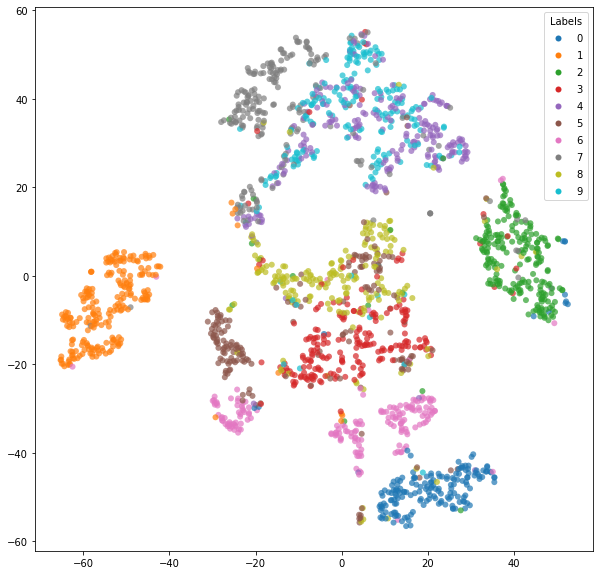

In [6]:
if LATENT_DIM == 2:
    z_train = model_vae.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train)
else:
    z_test = model_vae.encode_only_mu(x_test)
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_embeddings(z_tsne, y_test[0:2000], alpha=0.7)

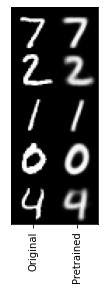

In [7]:
compare_orig_vs_pretrained = compare_reconstructed_images_MNIST(x_test, encoder, decoder, ("Original", "Pretrained"))

# Finetune the model

## Construct the full VaDE model

Load the pretrained weights for the encoder and decoder modules:

In [8]:
model_vae.load_weights("model_weights/cvae/pretrained/vae")

Construct the VaDE model:

In [9]:
N_CLUSTERS = 10
CLUSTERING_LOSS_WEIGHT = 0.1

EPOCHS = 100
BATCH_SIZE = 128
SCHEDULE = 10
DELTA_THRESHOLD = 0.01

model_cvae = ClusteringVAE(N_CLUSTERS, LATENT_DIM, encoder, decoder, CLUSTERING_LOSS_WEIGHT)

Initialize the model parameters from a K-means:

In [10]:
z_train = model_cvae.encode_only_mu(x_train)

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
kmeans.fit(z_train)

for weight in model_cvae.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(kmeans.cluster_centers_))

Evaluate the clustering performance before fine-tunning the model:

In [11]:
# Show the embeddings and the cluster centroids on the latent space
if LATENT_DIM == 2:
    z_train = model_vae.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train, centroids=kmeans.cluster_centers_)

Acc: 0.5512
ARI: 0.3520
AMI: 0.4982
Sil: 0.2362


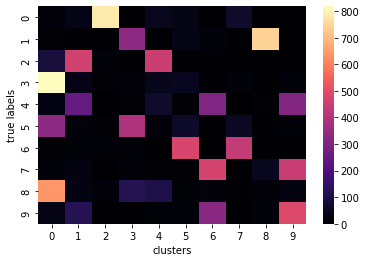

In [12]:
evaluate_clustering_performance(model_cvae.classify, x_test, y_test, True, model_cvae.encode_only_mu)

## Fine-tune the model

In [13]:
def update_p(q):
    """
    Compute the auxiliary distirbution P and update it
    Q = {q_ij} = soft cluster assignments
                      q_ij^2 / f_j
    P = {p_ij} = -------------------------
                  Sum_ij' (q_ij^2 / f_j')
    """
    weight = q ** 2 / tf.reduce_sum(q, axis=0)
    p = tf.transpose(tf.transpose(weight) / tf.reduce_sum(weight, axis=1))
    return p.numpy()


def delta_label(c_train):
    global c_last
    delta_label = np.sum(c_train != c_last).astype(np.float32) / c_train.shape[0]
    c_last = np.copy(c_train)
    print(f"Delta: {delta_label:.3f}")
    return delta_label


def cvae_callback(epoch, logs):
    global p
    if (epoch+1) % SCHEDULE == 0:
        q = model_cvae.soft_assignment(x_train)
        p = update_p(q)
        
        c_train = q.numpy().argmax(1)
        if (delta_label(c_train) < DELTA_THRESHOLD):
            model_cvae.stop_training = True

def get_cvae_callback():
    return [tf.keras.callbacks.LambdaCallback(on_epoch_end=cvae_callback)]

Initialize `p`, the auxiliary distribution to compute the clustering loss, and `c_last`, the last cluster assignments to compute the number of points that changed clusters.

In [14]:
p = update_p(to_categorical(kmeans.labels_))
c_last = model_cvae.classify(x_train)

Get the custom callback

In [15]:
callback = get_cvae_callback()

In [16]:
# def scheduler(epoch, lr):
#     if (epoch+1) % SCHEDULE == 0:
#         lr = lr * 0.9
#     return lr

# def print_accuracy(epoch, logs):
#     if (epoch+1) % SCHEDULE == 0:
#         c_test = model_vade.classify(x_test)
#         confusion_matrix = sklearn.metrics.confusion_matrix(y_test, c_test)
#         c_test = confusion_matrix.argmax(0)[c_test]
#         print(f"Current accuracy on test dataset: {sklearn.metrics.accuracy_score(y_test, c_test):.4f}")

# callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),
#             tf.keras.callbacks.LambdaCallback(on_epoch_end=print_accuracy)]

Train the model:

In [17]:
model_cvae.compile(optimizer=keras.optimizers.Adam())

model_cvae.fit(x_train, p,
               epochs=EPOCHS,
               batch_size=128,
               callbacks = callback,
               verbose=2,
              )

model_cvae.save_weights("model_weights/cvae/finetuned/cvae")

# model_cvae.load_weights("model_weights/cvae/finetuned/cvae")

Epoch 1/100
469/469 - 2s - total_loss: 142.9101 - reg_loss: 16.7042 - rec_loss: 22.2773 - clust_loss: 1039.2856 - 2s/epoch - 5ms/step
Epoch 2/100
469/469 - 2s - total_loss: 115.1155 - reg_loss: 20.4928 - rec_loss: 22.7390 - clust_loss: 718.8365 - 2s/epoch - 4ms/step
Epoch 3/100
469/469 - 2s - total_loss: 98.5528 - reg_loss: 22.3522 - rec_loss: 22.7079 - clust_loss: 534.9258 - 2s/epoch - 4ms/step
Epoch 4/100
469/469 - 2s - total_loss: 89.9160 - reg_loss: 23.9294 - rec_loss: 22.6511 - clust_loss: 433.3556 - 2s/epoch - 4ms/step
Epoch 5/100
469/469 - 2s - total_loss: 85.2676 - reg_loss: 25.3321 - rec_loss: 22.5668 - clust_loss: 373.6860 - 2s/epoch - 4ms/step
Epoch 6/100
469/469 - 2s - total_loss: 82.5480 - reg_loss: 26.6020 - rec_loss: 22.4926 - clust_loss: 334.5340 - 2s/epoch - 4ms/step
Epoch 7/100
469/469 - 2s - total_loss: 80.8539 - reg_loss: 27.5957 - rec_loss: 22.4306 - clust_loss: 308.2755 - 2s/epoch - 4ms/step
Epoch 8/100
469/469 - 2s - total_loss: 79.6030 - reg_loss: 28.4128 - rec_

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


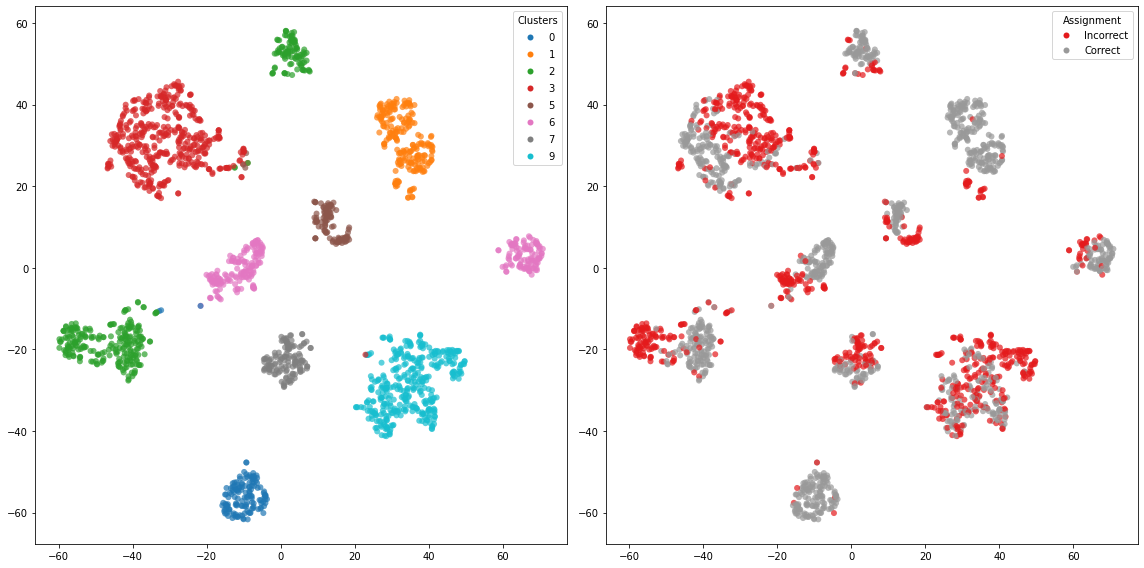

In [18]:
z_test = model_cvae.encode_only_mu(x_test)
c_test = model_cvae.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_clusters_assignments(z_tsne, y_test[0:2000], c_test[0:2000], alpha=0.7)

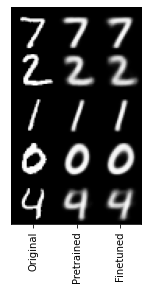

In [19]:
_ = compare_reconstructed_images_MNIST(x_test, encoder, decoder, ("Original", "Pretrained", "Finetuned"), old_figure=compare_orig_vs_pretrained)

## Evaluate the model

Acc: 0.5698
ARI: 0.3831
AMI: 0.5508
Sil: 0.8997


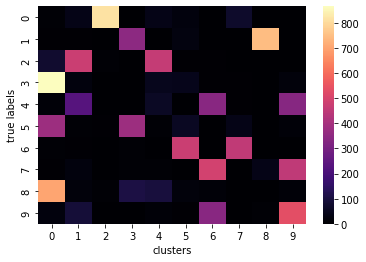

In [20]:
evaluate_clustering_performance(model_cvae.classify, x_test, y_test, True, model_cvae.encode_only_mu)